In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# MNIST Deep Learning

*by Johannes Bock*

MNIST is a simple computer vision dataset. It consists of images of handwritten digits like these:

![](https://www.tensorflow.org/images/MNIST.png)

The goal is to correctly identify digits from this dataset of tens of thousands of handwritten images. In order to achieve state of the art classification results I will use [Keras](https://keras.io/) and [Deep Convolutional Neural Networks](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721) in the following notebook. All models were trained on an AWS GPU Instance.

In [1]:
# Global settings
%matplotlib inline

random_state = 1
batchsize =2**12

## Dataset

The dataset contains a total of 60,000 training images of size 28x28. There are 10,000 test images on which the model will be evaluated.

In [2]:
from keras.datasets import mnist
(X_train, train_labels), (X_test, test_labels) = mnist.load_data()

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
import numpy as np

#Modify the shape of the data suitable for Keras
X_train = np.expand_dims(X_train,1)
X_test = np.expand_dims(X_test,1)
print X_train.shape
print X_test.shape

(60000, 1, 28, 28)
(10000, 1, 28, 28)


There are 10 classes to predict namely all numbers from 0 to 9.

In [4]:
#One-Hot Encode the labels
from keras.utils.np_utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

y_train.shape

(60000, 10)

Finally, for evaluation purposes 10% of the training data is being used as validation set.

In [5]:
# Split training data into training and validation set

from sklearn.cross_validation import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(y_train,n_iter=1, test_size=0.1, random_state=random_state)

for train_index, test_index in sss:
    
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]
    
print X_train.shape
print X_val.shape

(540000, 1, 28, 28)
(60000, 1, 28, 28)


## Model

The model architecture will be a deep convolutional neural network with the **input** of a fixed-size 28 × 28 black and white image. There is no data pre-processing as such, but rather the first layer of the model will perform Batchnormalization on the data which effectively is equivalent to **data normalization**. The image is passed through a stack of **convolutional layers**, where I use filters with a receptive field of 3 × 3. The spatial padding of conv. layer input is such that the spatial resolution is preserved after each convolution, i.e. the Zero-Padding is 1 pixel for 3 × 3 conv. layers. **Spatial Max-Pooling** is carried out after each convolutional block. Max-pooling is performed over a 2 × 2 pixel window, with stride 2.

The stack of convolutional layers includes two convolutional blocks with filter-size 32 and 64 respectively. Each convolutional block contains two layers.

The stack of convolutional layers is followed by two Fully-Connected layers. The first has 512 channels and the second performs 10-way digit classification and thus contains 10 channels (one for each class) with a softmax activation.

In [6]:
input_shape = X_train.shape[1:]
p = 0.

In [7]:
#Create model architecture

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam

def ConvBlock(model,layers, filters):
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
            model.add(BatchNormalization(axis=1))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
        
def get_model(p):
    model = Sequential()
    model.add(BatchNormalization(axis=1,input_shape=input_shape))

    ConvBlock(model,2,32)
    ConvBlock(model,2,64)

    model.add(Flatten())
    model.add(Dense(512,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(p))
    model.add(Dense(10,activation="softmax"))

    #Adam, Adagrad,RMSprop
    model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model1 = get_model(p)

In [9]:
model1.fit(X_train,y_train, nb_epoch=2, batch_size=batchsize,shuffle = True,
            validation_data=(X_val,y_val))

Train on 540000 samples, validate on 60000 samples
Epoch 1/2
540000/540000 [==============================] - 239s - loss: 0.2091 - acc: 0.9359 - val_loss: 2.3921 - val_acc: 0.3927
Epoch 2/2
540000/540000 [==============================] - 239s - loss: 0.0299 - acc: 0.9940 - val_loss: 1.5282 - val_acc: 0.5018


As you can see above, it turns out that this model is likely to overfit the data. Therefore, I decided to introduce some regularization using data augmentation.

## Data Augmentation

I will use some simple data augmentation techniques to introduce some noise. I will apply transformations on the data by rotating, shifting and zooming the images. This is a randomly selected example of an augmented training sample:

In [10]:
from keras.preprocessing import image

# Using Keras we can augment the image data by rotating, shifting and zooming the images

gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

trn_batches = gen.flow(X_train, y_train, batch_size=batchsize)
val_batches = gen.flow(X_val,y_val,batch_size = batchsize)
test_batches = gen.flow(X_test, y_test, batch_size=batchsize)

In [11]:
aX_test, ay_test = next(test_batches)

In [12]:
# Plot some augmented sample digits

import matplotlib.pyplot as plt

def to_plot(img):
    img = np.squeeze(img,axis=0)
    return img.astype(np.uint8)

def plot(img,title=None):
    plt.imshow(to_plot(img),cmap='Greys')
    if title: plt.title(title)

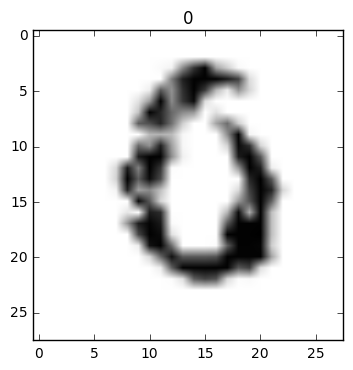

In [13]:
import random

idx = random.randint(0,aX_test.shape[0]-1)

plot(aX_test[idx],str(ay_test[idx].argmax()))

## Model No. 2 with augmented data

The second model will be identical to the first in terms of the architecture as you can see below, but it will be trained using augmented data.

In [14]:
p=0.
model2 = get_model(p)
model2.load_weights('model2.h5') #Already trained weights in an earlier session (15 epochs)

In [15]:
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_7 (BatchNormal(None, 1, 28, 28)     2           batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
zeropadding2d_5 (ZeroPadding2D)  (None, 1, 30, 30)     0           batchnormalization_7[0][0]       
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 32, 28, 28)    320         zeropadding2d_5[0][0]            
____________________________________________________________________________________________________
batchnormalization_8 (BatchNormal(None, 32, 28, 28)    64          convolution2d_5[0][0]            
___________________________________________________________________________________________

In [17]:
model2.optimizer.lr=0.0000001

In [18]:
model2.fit_generator(trn_batches, trn_batches.N, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/2
540000/540000 [==============================] - 240s - loss: 0.0285 - acc: 0.9916 - val_loss: 0.0278 - val_acc: 0.9915
Epoch 2/2
540000/540000 [==============================] - 241s - loss: 0.0291 - acc: 0.9912 - val_loss: 0.0285 - val_acc: 0.9912


In [19]:
model2.save_weights('model2_v2.h5')

As this model does not seem to overfit the data (equal testing and training accuracy) there is no need to use Dropout.

## Model No. 3 with augmented data

Model No. 3 is slightly different to the preceeding models as the stack of convolutional layers is followed by three Fully-Connected layers. The first and second layers have 256 channels and the third performs 10-way digit classification.

In [20]:
input_shape = X_train.shape[1:]
p = 0.

In [21]:
#Create model architecture
        
def get_model3(p):
    model = Sequential()
    model.add(BatchNormalization(axis=1,input_shape=input_shape))

    ConvBlock(model,2,32)
    ConvBlock(model,2,64)

    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(256,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(p))
    model.add(Dense(10,activation="softmax"))

    #Adam, Adagrad,RMSprop
    model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model3 = get_model3(p)

**Training history:**

In [23]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
540000/540000 [==============================] - 242s - loss: 0.4359 - acc: 0.8650 - val_loss: 2.9952 - val_acc: 0.1109
Epoch 2/3
540000/540000 [==============================] - 241s - loss: 0.1055 - acc: 0.9690 - val_loss: 2.0246 - val_acc: 0.2368
Epoch 3/3
540000/540000 [==============================] - 241s - loss: 0.0700 - acc: 0.9792 - val_loss: 0.3639 - val_acc: 0.8809


In [24]:
model3.optimizer.lr=0.00001

In [25]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
540000/540000 [==============================] - 241s - loss: 0.0537 - acc: 0.9841 - val_loss: 0.0740 - val_acc: 0.9791
Epoch 2/3
540000/540000 [==============================] - 241s - loss: 0.0451 - acc: 0.9864 - val_loss: 0.0475 - val_acc: 0.9858
Epoch 3/3
540000/540000 [==============================] - 240s - loss: 0.0388 - acc: 0.9883 - val_loss: 0.0378 - val_acc: 0.9887


In [26]:
model3.optimizer.lr=0.0000001

In [27]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/2
540000/540000 [==============================] - 241s - loss: 0.0334 - acc: 0.9899 - val_loss: 0.0315 - val_acc: 0.9901
Epoch 2/2
540000/540000 [==============================] - 240s - loss: 0.0304 - acc: 0.9909 - val_loss: 0.0282 - val_acc: 0.9913


In [28]:
model3.optimizer.lr=0.00000001

In [29]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=1, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/1
540000/540000 [==============================] - 241s - loss: 0.0271 - acc: 0.9918 - val_loss: 0.0257 - val_acc: 0.9918


In [31]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=1, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/1
540000/540000 [==============================] - 241s - loss: 0.0248 - acc: 0.9925 - val_loss: 0.0258 - val_acc: 0.9917


In [33]:
model3.optimizer.lr=0.000001

In [34]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=1, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/1
540000/540000 [==============================] - 241s - loss: 0.0230 - acc: 0.9930 - val_loss: 0.0220 - val_acc: 0.9932


In [35]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=1, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/1
540000/540000 [==============================] - 241s - loss: 0.0211 - acc: 0.9936 - val_loss: 0.0197 - val_acc: 0.9939


In [37]:
model3.optimizer.lr=0.00001

In [38]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=1, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/1
540000/540000 [==============================] - 241s - loss: 0.0196 - acc: 0.9940 - val_loss: 0.0198 - val_acc: 0.9938


In [39]:
model3.fit_generator(trn_batches, trn_batches.N, nb_epoch=1, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/1
540000/540000 [==============================] - 241s - loss: 0.0180 - acc: 0.9945 - val_loss: 0.0186 - val_acc: 0.9943


In [40]:
model3.save_weights('model3.h5')

## Evaluate models

To assess the performance of the models, I will test them on totally new and unseen data. In this case 10,000 images.

The performance of model 2 and model 3 respectively is as follows:

In [41]:
import keras

# Calculate the testing accuracy of model 2
preds2 = model2.predict(X_test)
keras.metrics.categorical_accuracy(y_test, preds2).eval()

array(0.9944000244140625, dtype=float32)

In [42]:
# Calculate the testing accuracy of model 3
preds3 = model3.predict(X_test)
keras.metrics.categorical_accuracy(y_test, preds3).eval()

array(0.9958999752998352, dtype=float32)

**Model prediction examples:**

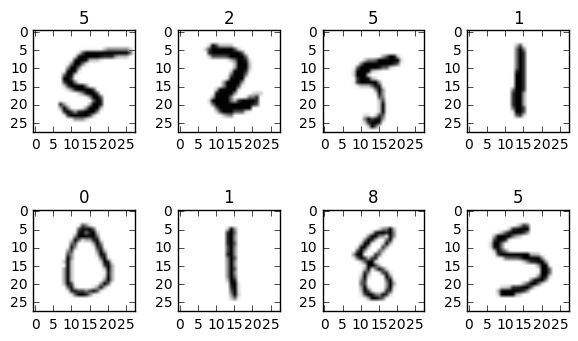

In [49]:
#Plot a grid of random sample predictions

for i in range(1,9):
    plt.subplot(240+i) #plt.subplot(nrows, ncols, plot_number)
    plt.tight_layout()
    idx = random.randint(0,aX_test.shape[0]-1)
    plot(X_test[idx],str(preds3[idx].argmax()))

The best state of the art is according to [this collection of research papers](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html) a classification error of **0.21 %**. My best model achieved a classification error of **0.41%** (i.e. Top20 of the current state of the art).